In [1]:
import pickle
import json
import numpy as np
import cv2
import pycocotools.mask as mask_util
import torch
import quaternion
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.structures import Boxes, BoxMode, Instances, pairwise_iou
from detectron2.utils.visualizer import GenericMask, ColorMode

In [2]:
with open('/Pool1/users/jinlinyi/workspace/p-sparse-plane/sparsePlane/datasets/mp3d_planercnn_json_v6/cached_set_test.json', 'r') as f:
    dataset_dicts = json.load(f)

Solution 1: Solve by reprojection $\mathrm{Mask}_A\rightarrow\mathrm{PCD}_A\rightarrow\mathrm{PCD}_B\rightarrow\mathrm{Mask}_B$

corr [[3, 4], [6, 5], [13, 7], [15, 8]]


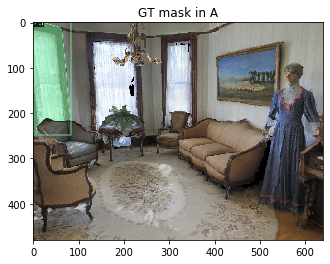

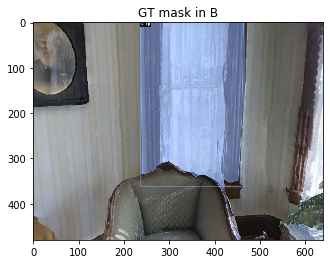

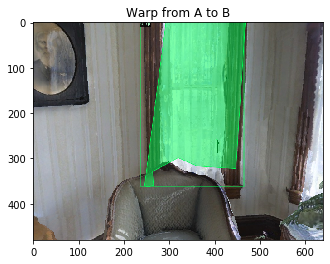

In [3]:
def segm2mask(segm, image_height, image_width):
    """
    convert coco format segmentation mask to binary mask
    """
    if isinstance(segm, list):
        polygons = [np.array(p, dtype=np.float64) for p in segm]
        rles = mask_util.frPyObjects(polygons, image_height, image_width)
        rle = mask_util.merge(rles)
    elif isinstance(segm, dict):  # RLE
        rle = segm
    else:
        raise TypeError(f"Unknown segmentation type {type(segm)}!")
    return mask_util.decode(rle)

def get_pcd(verts, normal, offset, h=480, w=640, focal_length = 517.97):
    """
    convert 2d verts to 3d point cloud based on plane normal and offset
    depth = offset / n \dot K^{-1}q
    """
    offset_x = w/2
    offset_y = h/2
    K = [[focal_length, 0, offset_x],
        [0, focal_length, offset_y],
        [0, 0, 1]]
    K_inv = np.linalg.inv(np.array(K))
    homogeneous = np.hstack((verts, np.ones(len(verts)).reshape(-1,1)))
    ray = K_inv@homogeneous.T
    depth = offset / np.dot(normal, ray)
    pcd = depth.reshape(-1,1) * ray.T
    return pcd


def transform_verts_list(verts_list, camera_info):
    """
    input: 
    @meshes: verts_list in local frame
    @camera_info: plane params from camera info, type = dict, must contain 'position' and 'rotation' as keys
    output:
    verts_list in global frame.
    """
    tran = camera_info['position']*np.array([1, -1, -1])
    rot = quaternion.from_float_array(camera_info['rotation'])
    rot_matrix = quaternion.as_rotation_matrix(rot)
    rot_matrix = np.diag([1,-1,-1]) @ rot_matrix @ np.diag([1,-1,-1])
    rot_matrix = torch.tensor(rot_matrix, dtype=torch.float32)
    verts_packed = torch.tensor(verts_list, dtype=torch.float32)
    verts_packed = verts_packed
    verts_packed = torch.mm(rot_matrix, verts_packed.T).T + torch.tensor(tran, dtype=torch.float32)
    verts_list = verts_packed.numpy()
    return verts_list


def pcd_to_vert(pcd, h=480, w=640, focal_length = 517.97):
    offset_x = w/2
    offset_y = h/2
    K = [[focal_length, 0, offset_x],
        [0, focal_length, offset_y],
        [0, 0, 1]]
    homogeneous = (K @ pcd.T).T
    verts = homogeneous / homogeneous[:, 2:]
    return verts[:,:2]
    
def get_gt_labeled_seg(dic, vis, assigned_colors=None, paper_img=False):
    """
    Draw annotations/segmentaions in Detectron2 Dataset format.
    Args:
        dic (dict): annotation/segmentation data of one image, in Detectron2 Dataset format.
    Returns:
        output (VisImage): image object with visualizations.
    """
    annos = dic.get("annotations", None)
    if annos:
        if "segmentation" in annos[0]:
            masks = [x["segmentation"] for x in annos]
        else:
            masks = None

        boxes = [BoxMode.convert(x["bbox"], BoxMode(x["bbox_mode"]), BoxMode.XYXY_ABS) for x in annos]

        labels = [f'{idx}: gt' for idx in range(len(annos))]
        if paper_img:
            labels=None
            boxes=None
        vis.overlay_instances(
            labels=labels, boxes=boxes, masks=masks, assigned_colors=assigned_colors,
        )
    seg_gt = vis.output.get_image()
    return seg_gt
pair_id = 10
print("corr", dataset_dicts['data'][pair_id]['gt_corrs'])
a_ind = 3
b_ind = 4

segm_a = dataset_dicts['data'][pair_id]['0']['annotations'][a_ind]['segmentation']
plane_a = dataset_dicts['data'][pair_id]['0']['annotations'][a_ind]['plane']
offset_a = np.linalg.norm(plane_a)
normal_a = plane_a / offset_a

vert_a = []
for s in segm_a:
    vert_a.extend(np.array(s).reshape(-1, 2))
pcd_a = get_pcd(vert_a, normal_a, offset_a, h=dataset_dicts['data'][pair_id]['0']['height'], w=dataset_dicts['data'][pair_id]['0']['width'])
pcd_b = transform_verts_list(pcd_a, dataset_dicts['data'][pair_id]['rel_pose'])
segm_b = pcd_to_vert(pcd_b, h=dataset_dicts['data'][pair_id]['0']['height'], w=dataset_dicts['data'][pair_id]['0']['width'])
segm_b_poly = []
start = 0
for s in segm_a:
    segm_b_poly.append(segm_b[start:start+int(len(s)/2), :].flatten().tolist())
    start += int(len(s)/2)
img = cv2.imread(dataset_dicts['data'][pair_id]['0']['file_name'], cv2.IMREAD_COLOR)
img = cv2.resize(img, (640, 480))
vis = Visualizer(img)
img_gt = get_gt_labeled_seg({'annotations': [dataset_dicts['data'][pair_id
                                                                  ]['0']['annotations'][a_ind]]}, vis)
plt.imshow(img_gt[:,:,::-1])
plt.title("GT mask in A")
plt.show()

img = cv2.imread(dataset_dicts['data'][pair_id]['1']['file_name'], cv2.IMREAD_COLOR)
img = cv2.resize(img, (640, 480))
vis = Visualizer(img)
img_gt = get_gt_labeled_seg({'annotations': [dataset_dicts['data'][pair_id]['1']['annotations'][b_ind]]}, vis)
plt.imshow(img_gt[:,:,::-1])
plt.title("GT mask in B")
plt.show()

img = cv2.imread(dataset_dicts['data'][pair_id]['1']['file_name'], cv2.IMREAD_COLOR)
img = cv2.resize(img, (640, 480))
vis = Visualizer(img)
warped = {'annotations': [dataset_dicts['data'][pair_id]['1']['annotations'][b_ind].copy()]}
warped['annotations'][0]['segmentation'] = segm_b_poly
img_gt = get_gt_labeled_seg(warped, vis)
plt.imshow(img_gt[:,:,::-1])
plt.title("Warp from A to B")
plt.show()

Solution 2: Solve for homography matrix analytically. Reference https://en.wikipedia.org/wiki/Homography_(computer_vision)

In frame A, for a plane parameter $[n, d]$ and a 3D point $P$ on the plane, we have $n^\intercal P^A_i - d = 0$,

then we have $t=t\cdot 1=t\cdot \frac{n^\intercal P^A_i}{d}$.

Our camera parameter gives $RP^A+t = P^B = HP^A$,

we get $H = R + \frac{t\cdot n^\intercal}{d}$.

[[ 8.73174448e-01 -6.75764704e-02  1.43520092e+02]
 [-1.13490545e-01  1.03202161e+00 -6.85727369e+01]
 [-7.22194070e-04  2.33697320e-04  4.57916356e-01]]


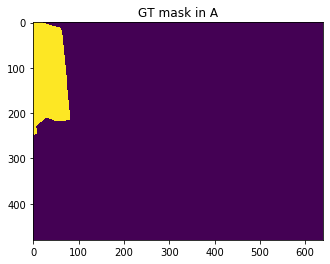

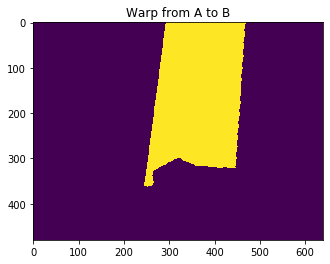

In [4]:
def get_homography(camera_info, plane_param, h=480, w=640, focal_length = 517.97):
    # solve analytically https://en.wikipedia.org/wiki/Homography_(computer_vision)
    R = quaternion.as_rotation_matrix(quaternion.from_float_array(camera_info['rotation']))
    R = np.diag([1,-1,-1]) @ R @ np.diag([1,-1,-1])
    t = np.array(camera_info['position']) * np.array([1, -1, -1])
    d = np.linalg.norm(plane_param)
    n = plane_param / max(d, 1e-6)
    H = R + t.reshape(3,1)@n.reshape(1, 3) / d
    
    offset_x = w/2
    offset_y = h/2
    K = [[focal_length, 0, offset_x],
        [0, focal_length, offset_y],
        [0, 0, 1]]
    H = K @ H @ np.linalg.inv(K)
    return H


plane_a = dataset_dicts['data'][pair_id]['0']['annotations'][a_ind]['plane']
camera_info = dataset_dicts['data'][pair_id]['rel_pose']
H = get_homography(camera_info, plane_a)
print(H)
mask_a = segm2mask(dataset_dicts['data'][pair_id]['0']['annotations'][a_ind]['segmentation'],  dataset_dicts['data'][pair_id]['0']['height'], dataset_dicts['data'][pair_id]['0']['width'])
mask_a_to_b = cv2.warpPerspective(mask_a.astype(np.uint8), H, (dataset_dicts['data'][pair_id]['0']['width'], dataset_dicts['data'][pair_id]['0']['height']))
plt.imshow(mask_a)
plt.title("GT mask in A")
plt.show()
plt.imshow(mask_a_to_b)
plt.title("Warp from A to B")
plt.show()